In [1]:
import torch
from transformers import AutoModelForSequenceClassification

print("PyTorch Î≤ÑÏ†Ñ:", torch.__version__)
print("is CUDA available:", torch.cuda.is_available())

PyTorch Î≤ÑÏ†Ñ: 1.10.2+cu113
is CUDA available: True


In [2]:
import pandas as pd

In [3]:
review_df = pd.read_csv('./labeled_reviews_lmstudio_cleaned.csv')
review_df.head()

content  label      model_used
0                             ^      2  gemma-lmstudio
1                      ^^\nÏ¢ãÏïÑÏöî~      2  gemma-lmstudio
2                            ^^      2  gemma-lmstudio
3  ^^ ÎèôÏ∞ΩÎ™®ÏûÑ Í≥†Í∏âÏä§ÎüΩÍ≥† ÎßõÏûàÎäî ÏΩîÏä§Î°ú Î®πÏóàÏñ¥Ïöî!!      2  gemma-lmstudio
4                      ^^ ÎßõÎÇòÏö©~~      2  gemma-lmstudio

In [7]:
print(review_df.isnull().sum())

content       1
label         0
model_used    0
dtype: int64


In [9]:
review_df = review_df.dropna()
print(review_df.isnull().sum())

content       0
label         0
model_used    0
dtype: int64


In [11]:
import numpy as np

cleaned_review = []

for review in review_df['content']:
  if len(review) < 2:
      review = np.nan
  else:
    if review == '':
      review = np.nan

    review = review.strip()

    if '\n' in review:
      review = review.replace('\n', '')

  cleaned_review.append(review)

review_df['content'] = cleaned_review

In [13]:
# Í≤∞Ï∏°Ïπò ÌôïÏù∏
print(review_df.isnull().sum())

content       184
label           0
model_used      0
dtype: int64


In [15]:
# Í≤∞Ï∏°Ïπò Ï†úÍ±∞
review_df = review_df.dropna()

# Í≤∞Ï∏°Ïπò ÌôïÏù∏
print(review_df.isnull().sum())

content       0
label         0
model_used    0
dtype: int64


In [17]:
# Ï§ëÎ≥µÏπò ÌôïÏù∏
print("Ï§ëÎ≥µ Ìñâ Í∞úÏàò:", review_df.duplicated().sum())

Ï§ëÎ≥µ Ìñâ Í∞úÏàò: 51


In [19]:
# Ï§ëÎ≥µÏπò Ï†úÍ±∞
review_df = review_df.drop_duplicates()

# Ï†úÍ±∞ ÌõÑ Í∞úÏàò
print("Ï§ëÎ≥µÏπò Ï†úÍ±∞ ÌõÑ Ìñâ Í∞úÏàò :", len(review_df))

Ï§ëÎ≥µÏπò Ï†úÍ±∞ ÌõÑ Ìñâ Í∞úÏàò : 368833


In [21]:
# Î≤îÏ£ºÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Ïàò Ï∞®Ïù¥ ÌôïÏù∏ÏùÑ ÏúÑÌï¥ label groupby ÏßëÍ≥Ñ
review_df.groupby('label').size().reset_index(name='count')

label   count
0      0   20852
1      1   49428
2      2  298553

In [23]:
sample_size = review_df['label'].value_counts().min()
balanced_df = review_df.groupby('label').sample(n=sample_size, random_state=42)
print("Balanced class counts:\n", balanced_df['label'].value_counts())

Balanced class counts:
 label
0    20852
1    20852
2    20852
Name: count, dtype: int64


In [25]:
# Î∂ÑÎ¶¨
input_list = balanced_df['content'].tolist()
label_list = balanced_df['label'].tolist()

In [ ]:
balanced_df.groupby('label').size().reset_index(name='count')

In [27]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import torch

In [29]:
# 1. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
df = balanced_df[['content', 'label']].copy()
df.columns = ['text', 'label']  # HuggingFace ÌòïÏãùÏóê ÎßûÍ≤å Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω

In [31]:
# 2. train/test Î∂ÑÎ¶¨ (stratify)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

In [33]:
# 3. ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î∞è Ï†ÑÏ≤òÎ¶¨
model_name = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)

C:\Users\User\anaconda3\envs\deepnlpenv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

C:\Users\User\anaconda3\envs\deepnlpenv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--beomi--KcELECTRA-base-v2022. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [35]:
def preprocess(batch):
    return tokenizer(batch['text'], truncation=True, max_length=128)

In [37]:
train_dataset = train_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/50044 [00:00<?, ? examples/s]

Map:   0%|          | 0/12512 [00:00<?, ? examples/s]

In [ ]:
from datasets import Value

# 4. ÎùºÎ≤® ÌÉÄÏûÖ Ï†ïÏàòÌòïÏúºÎ°ú ÏßÄÏ†ï
train_dataset = train_dataset.cast_column("label", Value("int64"))
test_dataset = test_dataset.cast_column("label", Value("int64"))

In [ ]:
# 3. Config ÏßÅÏ†ë ÏÑ§Ï†ï (Dropout Ï°∞Ï†ï)
config = ElectraConfig.from_pretrained(
    model_name,
    num_labels=3,
    hidden_dropout_prob=0.4,               # ‚úÖ hidden layer dropout ÌôïÎ•† Ï°∞Ï†ï
    attention_probs_dropout_prob=0.4       # ‚úÖ self-attention dropout ÌôïÎ•† Ï°∞Ï†ï
)

In [ ]:
# 4. Î™®Îç∏ ÏÉùÏÑ± (ÏúÑ config ÏÇ¨Ïö©)
model_0624_5 = ElectraForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

In [39]:
# 5. Load the pre-trained model (with classification head for 3 classes)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

C:\Users\User\anaconda3\envs\deepnlpenv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some weights of the model checkpoint at beomi/KcELECTRA-base-v2022 were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'c

In [41]:
# 4. ÌèâÍ∞ÄÏßÄÌëú Ìï®Ïàò Ï†ïÏùò
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": (preds == labels).mean(),
        "macro_f1": f1_score(labels, preds, average="macro")
    }

In [ ]:
from torch.nn import CrossEntropyLoss

# ÌÅ¥ÎûòÏä§Î≥Ñ Í∞ÄÏ§ëÏπò: (ÏòàÏãú) [Î∂ÄÏ†ï:1.0, Ï§ëÎ¶Ω:2.0, Í∏çÏ†ï:1.0]
class_weights = torch.tensor([1.0, 2.0, 1.0]).to(model_0624_5.device)

# Custom Trainer Ï†ïÏùò
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # GPUÎ°ú class weight Î≥¥ÎÇ¥Í∏∞
        weight = class_weights.to(model.device)
        loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [43]:
# 5. Trainer ÌïôÏäµ ÏÑ§Ï†ï
training_args = TrainingArguments(
    output_dir="./best_model",
    evaluation_strategy="steps",
    eval_steps=500,                 # evaluate every 500 steps
    save_strategy="steps",
    save_steps=500,                 # save checkpoint every 500 steps
    save_total_limit=2,             # keep only the 2 most recent checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    
    num_train_epochs=6,
    per_device_train_batch_size=64,  # use 64 if possible (else reduce to 32)
    per_device_eval_batch_size=64,
    
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_steps=500,               # ~5% of training steps as warm-up
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=100,              # log every 100 steps
    
    fp16=True,                      # enable mixed precision for speed
    report_to=[],                   # disable default logging (TensorBoard, etc.)
    seed=42
)

In [45]:
# 8. Initialize Trainer with early stopping callback
from transformers import EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,            # using our test_df as validation set for early stopping
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),  # dynamic padding to longest in batch
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

Using cuda_amp half precision backend


In [47]:
# 6. ÌïôÏäµ Ïã§Ìñâ
trainer.train()

The following columns in the training set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\User\anaconda3\envs\deepnlpenv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50044
  Num Epochs = 6
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 4692
  Number of trainable parameters = 127779075
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is

The following columns in the evaluation set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12512
  Batch size = 64
Saving model checkpoint to ./best_model\checkpoint-500
Configuration saved in ./best_model\checkpoint-500\config.json
Model weights saved in ./best_model\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ./best_model\checkpoint-500\tokenizer_config.json
Special tokens file saved in ./best_model\checkpoint-500\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125

TrainOutput(global_step=3500, training_loss=0.5630141350882394, metrics={'train_runtime': 1038.1374, 'train_samples_per_second': 289.233, 'train_steps_per_second': 4.52, 'total_flos': 1.3623544099180512e+16, 'train_loss': 0.5630141350882394, 'epoch': 4.48})

In [48]:
# 7. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏°
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

The following columns in the test set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 12512
  Batch size = 64


In [49]:
# 8. Í≤∞Í≥º Î¶¨Ìè¨Ìä∏ Ï∂úÎ†•
print(classification_report(y_true, y_pred, target_names=["Î∂ÄÏ†ï", "Ï§ëÎ¶Ω", "Í∏çÏ†ï"]))

              precision    recall  f1-score   support

          Î∂ÄÏ†ï       0.88      0.73      0.80      4170
          Ï§ëÎ¶Ω       0.65      0.66      0.66      4171
          Í∏çÏ†ï       0.69      0.80      0.74      4171

    accuracy                           0.73     12512
   macro avg       0.74      0.73      0.73     12512
weighted avg       0.74      0.73      0.73     12512



The following columns in the test set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 12512
  Batch size = 64


              precision    recall  f1-score   support

          Î∂ÄÏ†ï       0.88      0.73      0.80      4170
          Ï§ëÎ¶Ω       0.65      0.66      0.66      4171
          Í∏çÏ†ï       0.69      0.80      0.74      4171

    accuracy                           0.73     12512
   macro avg       0.74      0.73      0.73     12512
weighted avg       0.74      0.73      0.73     12512



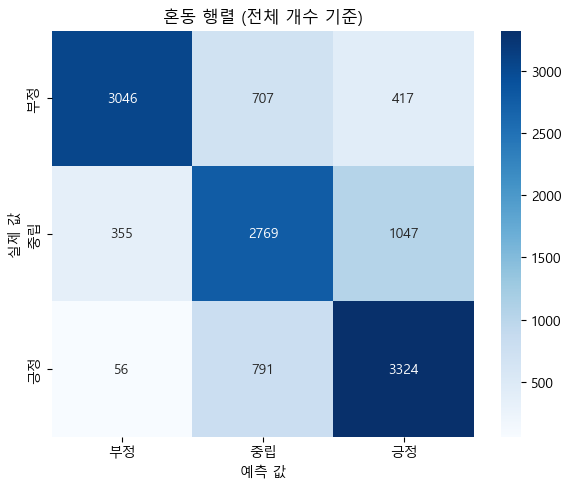

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# ‚úÖ ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False  # ÏùåÏàò Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ

# ‚úÖ 1. ÏòàÏ∏°Í∞í
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

# ‚úÖ 2. classification report
print(classification_report(y_true, y_pred, target_names=["Î∂ÄÏ†ï", "Ï§ëÎ¶Ω", "Í∏çÏ†ï"]))

# ‚úÖ 3. confusion matrix ÏãúÍ∞ÅÌôî (seaborn + Ï†ÑÏ≤¥ Ïàò Í∏∞Ï§Ä)
cm = confusion_matrix(y_true, y_pred)  # normalize=None ÏÉÅÌÉú Ïú†ÏßÄ

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Î∂ÄÏ†ï', 'Ï§ëÎ¶Ω', 'Í∏çÏ†ï'],
            yticklabels=['Î∂ÄÏ†ï', 'Ï§ëÎ¶Ω', 'Í∏çÏ†ï'])

plt.xlabel('ÏòàÏ∏° Í∞í')
plt.ylabel('Ïã§Ï†ú Í∞í')
plt.title('ÌòºÎèô ÌñâÎ†¨ (Ï†ÑÏ≤¥ Í∞úÏàò Í∏∞Ï§Ä)')
plt.tight_layout()
plt.show()


In [53]:
# 9. Î™®Îç∏ Ï†ÄÏû•
trainer.save_model("./kc_electra_sentiment_model_0624_6")

Saving model checkpoint to ./kc_electra_sentiment_model_0624_6
Configuration saved in ./kc_electra_sentiment_model_0624_6\config.json
Model weights saved in ./kc_electra_sentiment_model_0624_6\pytorch_model.bin
tokenizer config file saved in ./kc_electra_sentiment_model_0624_6\tokenizer_config.json
Special tokens file saved in ./kc_electra_sentiment_model_0624_6\special_tokens_map.json


In [63]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Î™®Îç∏Í≥º ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎî©
model_path = "./kc_electra_sentiment_model_0624_6"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# 2. GPU/CPU Ïû•Ïπò ÏÑ§Ï†ï
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 3. Í∞êÏÑ± Î†àÏù¥Î∏î
labels = ['Î∂ÄÏ†ï', 'Ï§ëÎ¶Ω', 'Í∏çÏ†ï']

# 4. ÏòàÏ∏° Ìï®Ïàò
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # ‚úÖ ÏûÖÎ†•ÎèÑ GPUÎ°ú Ïù¥Îèô
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)[0]
        label_idx = torch.argmax(probs).item()
        return labels[label_idx], float(probs[label_idx])

# 5. ÌÖåÏä§Ìä∏Ïö© Î¶¨Î∑∞ ÏÉòÌîå
sample_reviews = [
    "ÏßÑÏßú ÎßõÏóÜÍ≥† ÏµúÏïÖÏù¥ÏóàÏñ¥Ïöî.",
    "Í∑∏ÎÉ• Í∑∏Îû¨Ïñ¥Ïöî. Î¨¥ÎÇúÌïú Ìé∏Ïù¥ÏóêÏöî.",
    "ÏßÑÏßú Ï°¥ÎßõÌÉ±!! Îòê Ïò¨ Í±∞ÏòàÏöî~",
    "ÏÑúÎπÑÏä§Îäî Î≥ÑÎ°úÏòÄÏßÄÎßå ÏùåÏãùÏùÄ Í¥úÏ∞ÆÏïòÏñ¥Ïöî.",
    "ÏúÑÏÉù ÏÉÅÌÉúÍ∞Ä Ï¢Ä ÏùòÏã¨Ïä§ÎüΩÎÑ§Ïöî.",
    "Ïò§Îûò Í∏∞Îã§Î†∏ÏßÄÎßå ÎßõÏûàÏñ¥Ïöî",
    "Ìåå Î∂ÑÎ™ÖÌûà ÎπºÎã¨ÎùºÍ≥† ÏöîÏ≤≠ÌñàÎäîÎç∞ Í≥†ÏùòÏù∏ÏßÄ Ïã§ÏàòÏù∏ÏßÑ Î™®Î•¥Í≤†ÏßÄÎßå Í≤∞Íµ≠Ïóê ÎÑ£ÏúºÏÖ®ÎçîÎùºÍ≥†Ïöî ÏÇ¨Îûå Îßê Ï¢Ä Ï†úÎåÄÎ°ú Îì§Ïñ¥Ï£ºÏÑ∏Ïöî ÎßõÏùÄ ÎßõÏûàÏñ¥Ïöî",
    "Îä¶ÏùÄÏãúÍ∞Ñ Ï†ÄÎÖÅÏù¥Îùº ÌÑ∞ÎØ∏ÎÑê Ïïû ÍπÄÎ∞•Ï≤úÍµ≠ 24ÏãúÍ∞Ñ ÌïòÎäîÍ≥≥ÏúºÎ°ú Î∞©Î¨∏ÌñàÏäµÎãàÎã§ Î©îÎâ¥ÌåêÏóê Ï†ïÎßê Îã§ÏñëÌïú Î©îÎâ¥Îì§Ïù¥ ÏûàÏóàÏäµÎãàÎã§ ÌÖåÏù¥Î∏îÎèÑ ÎßéÍ≥† ÌòºÎ∞•ÌïòÏãúÎäî Î∂ÑÎì§ÏùÑ ÏúÑÌïú ÏûêÎ¶¨ÎèÑ ÎßéÏù¥ ÏûàÏñ¥Ïöî ÏùåÏãùÎèÑ Îπ®Î¶¨ ÎÇòÏò§Í≥† ÌïòÎÇò Í∞ôÏù¥ Îã§ Î®πÏùåÏßÅÏä§ÎüΩÍ≤å ÏÉùÍ≤ºÏñ¥Ïöî Ïó¨Í∏∞Îäî Îã§Î•∏ÏßÄÏ†êÏóê Í±∞Ïùò Î™ªÎ≥∏ Í≥±Î∞∞Í∏∞ÎèÑ ÏûàÎçîÎùºÍµ¨Ïöî ÎÑàÎ¨¥ ÎßéÏù¥ ÏãúÏºúÏÑú ÎùºÎ≥∂Ïù¥Îäî Ï¢Ä ÎÇ®Í∏∞Í∏¥ ÌñàÏßÄÎßå Ïûò Î®πÍ≥† ÏôîÏñ¥Ïöî Ïó¨Í∏∞Îäî Îä¶ÏùÄÏãúÍ∞ÑÏóê Ïò§ÏãúÎäî ÏÜêÎãòÎèÑ Ï†ïÎßê ÎßéÏßÄÎßå Î∞∞Îã¨Ïù¥ Ï†ïÎßê ÎßéÎçîÎùºÍµ¨Ïöî ÏùåÏãùÎì§Ïù¥ Îã§ ÌèâÌÉÄÏù¥ÏÉÅÏù¥Îùº Î≠ò ÏãúÏºúÎèÑ ÎØøÍ≥† Î®πÏùÑÏàò ÏûàÏùÑÍ±∞ Í∞ôÏïÑÏöî",
    "Î¶¨Î™®Îç∏ÎßÅÌïòÍ≥†Îäî Ï≤òÏùå Í∞ÄÎ≥¥ÎÑ§Ïöî ÎπÑÏä∑ÌïúÎç∞ ÍπîÎÅîÌï¥ÏßÄÍ≥† ÎÅùÏù¥ Î≤Ω Î≥¥Í≤å Î∞îÎÄåÏóàÎÑ§Ïöî Ï†ïÏàòÍ∏∞ ÏúÑÏπòÎèÑ Î∞îÎÄåÍ≥† Ï£ºÎ∞© ÏúÑÏ™ΩÏóê ÏùºÎ∂Ä Î©îÎâ¥Îì§ Ïç®ÏûàÎÑ§Ïöî Ï∞∏ÏπòÍπÄÎ∞• Ï£ºÎ¨∏ÌñàÏñ¥Ïöî 5Ï≤úÏõêÏù¥ÏóêÏöî Ïù¥Î†áÍ≤å ÎπÑÏãºÏ§Ñ Î™∞ÎûêÎÑ§Ïöî„Ö† ÏùºÎ∞òÎßå 3Ï≤úÏù∏Í∞Ä 3500Ïù∏Í∞Ä Í∑∏Î†áÍ≥† ÎÇòÎ®∏ÏßÑ 4500Î∂ÄÌÑ∞ ÏãúÏûëÏù¥ÎÑ§Ïöî ÍπÄÎ∞•Îßå ÎìúÏã§Í±∞Î©¥ ÏÑ†Î∂àÏù¥ÏóêÏöî ÍπªÏûéÏóê Ï∞∏Ïπò Ïã∏Ï†∏ÏûàÍ≥† ÎãπÍ∑º Ïö∞Ïóâ ÌñÑ Îã®Î¨¥ÏßÄ Í≥ÑÎûÄ Îì§Ïñ¥Í∞ÄÏöî ÍπªÏûéÏù¥ Îì§Ïñ¥Í∞ÄÏÑú Í∑∏Îü∞Í∞Ä Ïò§Ïù¥ÎÇò ÏãúÍ∏àÏπòÎäî ÏóÜÎÑ§Ïöî Í≤âÏóê Íπ® Ï°∞Í∏à ÎøåÎ†§Ï†∏ÏûàÏñ¥Ïöî Ï†ÑÏóî ÏóÑÏ≤≠ ÎßõÏûàÏóàÎäîÎç∞ Ïù¥Î≤àÏóî Í∑∏ÎÉ• ÎßõÏûàÎäî Ï†ïÎèÑ? Ï∞∏Ïπò ÏñëÎèÑ Ï†ÅÏñ¥ÏßÑ Í≤É Í∞ôÏùÄ ÎäêÎÇå",
    "ÏÜîÏßÅÌûà ÍπÄÎ∞•Ï≤úÍµ≠ÏùÄ Ï†êÎ∞îÏ†êÏù¥ Í∞ïÌïòÏûñÏïÑÏöî..ü•π Ïñ¥Îîò ÎßõÏûàÎäîÎç∞ Ïñ¥Îîò ÎßõÏóÜÍ≥†..Í∑∏Î¶¨Í≥† Î∂àÏπúÏ†àÌïòÍ±∞ÎÇò ÏúÑÏÉùÏ†ÅÏù¥ÏßÄ Î™ªÌïú Í≥≥ÎèÑ ÎßéÍ≥†Ìï¥ÏÑú Î∞©Î¨∏ÏùÑ ÏûòÏïàÌñàÎäîÎç∞ Ï≤≠Ï£ºÌÑ∞ÎØ∏ÎÑêÏ†êÏùÄ ÍπÄÎ∞•Ï≤úÍµ≠Ï§ëÏóêÏÑúÎèÑ Ï†úÏùº ÎßõÏûàÍ≥† ÏπúÏ†àÌïòÏÖîÏÑú ÎÑò Ï¢ãÎçîÎùºÍ≥†Ïöî~üíñ Í∑∏ÎûòÏÑú Í∑∏Îü∞Í∞Ä Îä¶ÏùÄÏãúÍ∞ÑÏûÑÏóêÎèÑ Î∂àÍµ¨ÌïòÍ≥† ÏãùÏÇ¨ÌïòÏãúÎäî ÏÜêÎãòÎì§Ïù¥ ÏóÑÏ≤≠ ÎßéÏïòÎäîÎç∞Ïöî, ÏãúÌÇ® Î©îÎâ¥ ÌïòÎÇòÌïòÎÇò Îã§ ÎßõÏûàÏñ¥ÏÑú ÎÜÄÎûêÎãµÎãàÎã§üëçüèªüëçüèªÏó≠Ïãú Í∑∏ÎûòÏÑú Í∑∏Îü∞ÏßÄ Î∞∞Îã¨Ïù¥Îûë Ìè¨Ïû•Ï£ºÎ¨∏ÎèÑ ÎßéÏùÄÎç∞ Î∞îÏÅúÎç∞ÎèÑ ÏßÅÏõêÎ∂ÑÎì§Ïù¥ ÏßúÏ¶ùÌïúÎ≤à ÏïàÎÇ¥ÏãúÍ≥† ÏπúÏ†àÌïòÍ≤å ÏùëÎåÄÌï¥Ï£ºÏÖîÏÑú Ï¢ãÏïòÏñ¥Ïöîü•∞ ÌïôÏÉùÎì§Ïù¥ ÏôÄÏÑú ÍπÄÎ∞•Ïóê Ïû¨Î£åÎ•º ÎπºÎã¨ÎùºÍ≥† ÍπåÎã§Î°≠Í≤å ÏöîÏ≤≠ÌïòÎäîÎç∞ÎèÑ ÏßúÏ¶ùÏóÜÏù¥ ÏπúÏ†àÌïòÍ≤å ÏùëÎåÄÌï¥Ï£ºÏãúÍ≥†..ü•πÏßÑÏßú 24ÏãúÍ∞ÑÏù∏ Ï†êÎèÑ Ï†ïÎßê Ï¢ãÍ≥† ÍπÄÎ∞•Ï≤úÍµ≠ ÏÉùÍ∞ÅÎÇ†ÎïåÎäî ÏßëÏóêÏÑúÎäî Î©ÄÍ∏¥ÌïòÏßÄÎßå ÏùºÎ∂ÄÎü¨ Ï≤≠Ï£ºÌÑ∞ÎØ∏ÎÑêÏ†êÏóê Î∞©Î¨∏ÌïòÍ≥† Ïã∂ÏùÑÏ†ïÎèÑÎ°ú Ï†úÍ∞Ä Î∞©Î¨∏ÌñàÎçò ÍπÄÎ∞•Ï≤úÍµ≠ Ï§ë ÎßõÎèÑ ÏπúÏ†àÎèÑ ÏµúÍ≥†ÏòÄÎãµÎãàÎã§üëçüèªüëçüèª",
    "Í≥µÏÇ¨ÌïòÍ≥† Íπ®ÎÅóÌï¥Ï°åÏñ¥Ïöî Ìï≠ÏÉÅ ÏÇ¨ÎûåÏù¥ ÎßéÏïÑÏöî.Í∞ÄÏÑ±ÎπÑ Ï¢ãÍ≥† Î©îÎâ¥ÎèÑ ÎßéÏïÑÏÑú Ïó¨Îü¨ Î™Ö Í∞ÄÏÑú Í∞ôÏù¥ Î®πÏñ¥Ïöî.",
    "Ï´ÑÎ©¥. Î©¥Ïù¥Îûë ÏΩ©ÎÇòÎ¨ºÏù¥ ÎÑàÎ¨¥ ÏïÑÏÇ≠? Ìï¥ÏÑú „Ö†.„Ö†",
    "Îä¶ÏùÄÏãúÍ∞Ñ ÌïúÎÅºÎ®πÍ∏∞Ïóê Ï¢ãÏùå Ïó≠Ïãú ÍπÄÏ≤úÏùÄ Ï†ïÏãùÏù¥ ÌïÑÏàòÏßÄ...Ï†úÏú°ÎçÆÎ∞•ÏùÄ ÎÑàÎ¨¥ Ïß¨. Î¶¨Î™®Îç∏ÎßÅÎÅùÎÇ¨Í∏∏Îûò Îã§ÎÖÄÏôîÎäîÎç∞ ÏùåÏãùÍ∞ÄÍ≤©Ïù¥ Ïò¨ÎûêÎÑ§.....Ï©ù",
    "Ïö∞ÏÑ† Ïª§ÌîºÍ∞Ä ÏòàÏà†Ïù¥ÏóêÏöî~Ï≤≠Ï£ºÏóêÏÑú Î≥¥Í∏∞ÎìúÎ¨∏ Í≥†ÌÄÑÏª§ÌîºÎßõÏù¥ÏóêÏöî~Ï†ïÎßê Ïª§ÌîºÏóê ÏßÑÏã¨Ïù∏ Í≥≥ Í∞ôÏïÑÏöî~ÎîîÏ†ÄÌä∏Î•òÎäî Í±∞Ïùò ÏóÜÍ≥† Ïª§ÌîºÏóê Ï£ºÎ†•ÌïòÏãúÎäî Í±∞ Í∞ôÏïÑÏöî~Ïª§Ìîº ÏßÑÏßú ÏµúÍ≥†ÏóêÏöî~Î∂ÑÏúÑÍ∏∞Îûë Ïù∏ÌÖåÎ¶¨Ïñ¥ÎèÑ ÎÑàÎ¨¥ Ï¢ãÏïÑÏÑú Îã§Ïãú ÌïúÎ≤à Îçî Î∞©Î¨∏ÌïòÍ≥†Ìîà Ïπ¥ÌéòÏóêÏöî~",
    "Ïñ¥Î†∏ÏùÑ Ï†Å Ìï†Î®∏ÎãàÍ∞Ä ÏÇ¨ÏãúÎçò Ïô∏Í∞ìÏßëÏù¥ Ïù¥Îü∞ Î∂ÑÏúÑÍ∏∞ÏòÄÏñ¥Ïöî. Î≤ΩÍ≥º Ï≤úÏû•Ïù¥ ÎÇòÎ¨¥Î°ú ÎêòÏñ¥ ÏûàÏñ¥ Îî∞Ïä§Ìïú Í≥≥Ïù¥Ïöî. Ï∞ΩÏóê ÎìúÎ¶¨Ïö¥ ÌñáÏÇ¥Í≥º ÏùåÏïÖ, Ïª§ÌîºÏùò Ï°∞Ìôî ... ÎçîÏóÜÏù¥ ÌèâÏò®ÌñàÏñ¥Ïöî ‚òï ÏûëÍ∞ÄÎì§Ïùò Ìï∏ÎìúÎ©îÏù¥Îìú Ï†úÌíàÎì§Ïù¥ Í≥≥Í≥≥Ïóê ÏûàÏñ¥ ÏöîÎ™®Ï°∞Î™® ÏÇ¥Ìé¥Î≥¥Í∏∞ÎèÑ Ï¢ãÍ≥† ÏÑ†Î¨ºÌïòÍ∏∞ Ï¢ãÏùÄ Ï†úÌíàÎì§Ïù¥ ÏûàÏñ¥ Î™áÍ∞ÄÏßÄ Íµ¨Îß§ÌïòÍ≥†Í∞ëÎãàÎã§ ! Ïπ¥ÌéòÏôÄ Ìé∏ÏßëÏàçÏù¥ Ï°∞ÌôîÎ°≠Í≤å Ïñ¥Ïö∏Î†§ ÏûàÏñ¥ Ï¢ãÏïòÍ≥† Îß§ Îã¨ ÎÇòÏò§Îäî Ïù¥ Í≥≥ÎßåÏùò ÏÜåÏãùÏßÄÍ∞Ä ÏûàÏóàÏñ¥Ïöî. Ïù¥ÏïºÍ∏∞ ÏûàÎäî Ïù¥ Í≥µÍ∞ÑÏóê Îã§Ïãú Î∞úÍ±∏Ïùå ÌïòÍ≥† Ïã∂Ïñ¥Ïöî üòç",
    "üò°üò°üò°üò†üò†üò†",
    "üò¢üò¢üò¢üí¢"
]

# 6. Í≤∞Í≥º Ï∂úÎ†•
for review in sample_reviews:
    label, prob = predict_sentiment(review)
    print(f"[{label}] ({prob:.2%}) - {review}")


loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file ./kc_electra_sentiment_model_0624_6\config.json
Model config ElectraConfig {
  "_name_or_path": "./kc_electra_sentiment_model_0624_6",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label

[Î∂ÄÏ†ï] (98.14%) - ÏßÑÏßú ÎßõÏóÜÍ≥† ÏµúÏïÖÏù¥ÏóàÏñ¥Ïöî.
[Ï§ëÎ¶Ω] (95.70%) - Í∑∏ÎÉ• Í∑∏Îû¨Ïñ¥Ïöî. Î¨¥ÎÇúÌïú Ìé∏Ïù¥ÏóêÏöî.
[Í∏çÏ†ï] (95.50%) - ÏßÑÏßú Ï°¥ÎßõÌÉ±!! Îòê Ïò¨ Í±∞ÏòàÏöî~
[Î∂ÄÏ†ï] (67.96%) - ÏÑúÎπÑÏä§Îäî Î≥ÑÎ°úÏòÄÏßÄÎßå ÏùåÏãùÏùÄ Í¥úÏ∞ÆÏïòÏñ¥Ïöî.
[Î∂ÄÏ†ï] (96.49%) - ÏúÑÏÉù ÏÉÅÌÉúÍ∞Ä Ï¢Ä ÏùòÏã¨Ïä§ÎüΩÎÑ§Ïöî.
[Í∏çÏ†ï] (72.82%) - Ïò§Îûò Í∏∞Îã§Î†∏ÏßÄÎßå ÎßõÏûàÏñ¥Ïöî
[Î∂ÄÏ†ï] (95.36%) - Ìåå Î∂ÑÎ™ÖÌûà ÎπºÎã¨ÎùºÍ≥† ÏöîÏ≤≠ÌñàÎäîÎç∞ Í≥†ÏùòÏù∏ÏßÄ Ïã§ÏàòÏù∏ÏßÑ Î™®Î•¥Í≤†ÏßÄÎßå Í≤∞Íµ≠Ïóê ÎÑ£ÏúºÏÖ®ÎçîÎùºÍ≥†Ïöî ÏÇ¨Îûå Îßê Ï¢Ä Ï†úÎåÄÎ°ú Îì§Ïñ¥Ï£ºÏÑ∏Ïöî ÎßõÏùÄ ÎßõÏûàÏñ¥Ïöî
[Ï§ëÎ¶Ω] (66.87%) - Îä¶ÏùÄÏãúÍ∞Ñ Ï†ÄÎÖÅÏù¥Îùº ÌÑ∞ÎØ∏ÎÑê Ïïû ÍπÄÎ∞•Ï≤úÍµ≠ 24ÏãúÍ∞Ñ ÌïòÎäîÍ≥≥ÏúºÎ°ú Î∞©Î¨∏ÌñàÏäµÎãàÎã§ Î©îÎâ¥ÌåêÏóê Ï†ïÎßê Îã§ÏñëÌïú Î©îÎâ¥Îì§Ïù¥ ÏûàÏóàÏäµÎãàÎã§ ÌÖåÏù¥Î∏îÎèÑ ÎßéÍ≥† ÌòºÎ∞•ÌïòÏãúÎäî Î∂ÑÎì§ÏùÑ ÏúÑÌïú ÏûêÎ¶¨ÎèÑ ÎßéÏù¥ ÏûàÏñ¥Ïöî ÏùåÏãùÎèÑ Îπ®Î¶¨ ÎÇòÏò§Í≥† ÌïòÎÇò Í∞ôÏù¥ Îã§ Î®πÏùåÏßÅÏä§ÎüΩÍ≤å ÏÉùÍ≤ºÏñ¥Ïöî Ïó¨Í∏∞Îäî Îã§Î•∏ÏßÄÏ†êÏóê Í±∞Ïùò Î™ªÎ≥∏ Í≥±Î∞∞Í∏∞ÎèÑ ÏûàÎçîÎùºÍµ¨Ïöî ÎÑàÎ¨¥ ÎßéÏù¥ ÏãúÏºúÏÑú Îùº

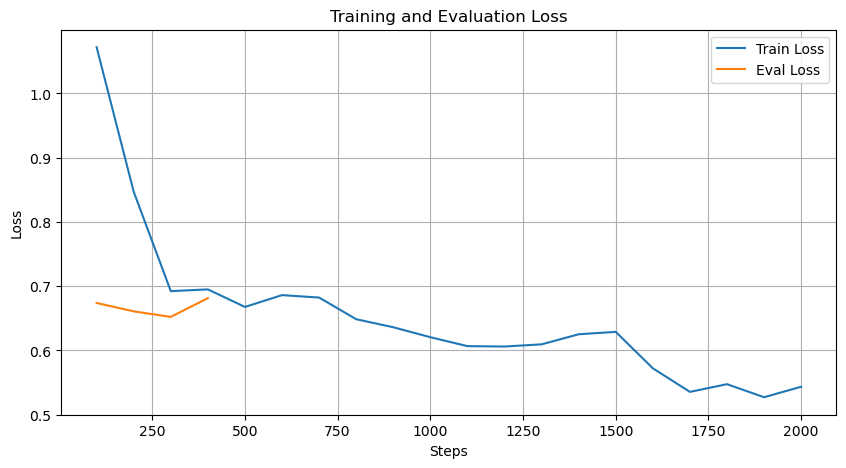

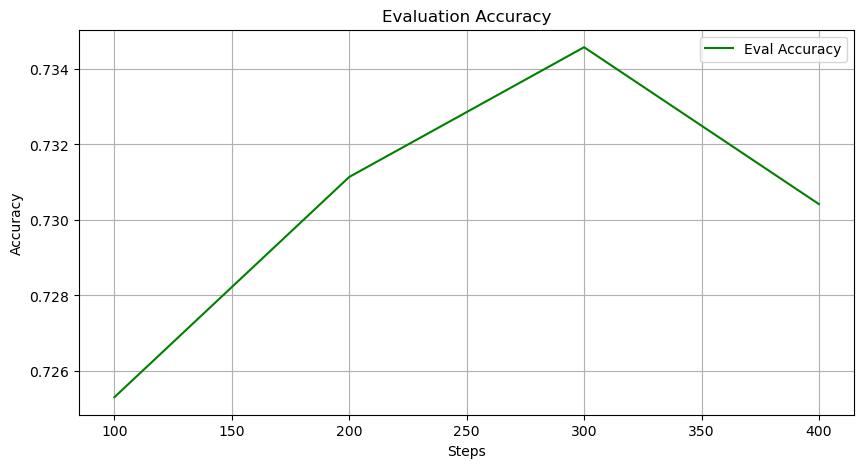

In [61]:
import json
import matplotlib.pyplot as plt

# trainer_state.json Í≤ΩÎ°ú
trainer_state_path = "./best_model/checkpoint-2000/trainer_state.json"

# JSON ÌååÏùº Î°úÎìú
with open(trainer_state_path, "r", encoding="utf-8") as f:
    trainer_state = json.load(f)

# Î°úÍ∑∏ ÎÇ¥Ïó≠ Ï∂îÏ∂ú
logs = trainer_state["log_history"]

# Í∞í Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
steps, train_loss, eval_loss, eval_accuracy = [], [], [], []

# Î°úÍ∑∏ ÏàúÌöå
for entry in logs:
    if "loss" in entry and "step" in entry:
        steps.append(entry["step"])
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        eval_accuracy.append(entry["eval_accuracy"])

# üîπ 1. Loss Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label="Train Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# üîπ 2. Accuracy Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10, 5))
plt.plot(steps[:len(eval_accuracy)], eval_accuracy, label="Eval Accuracy", color="green")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
